<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/market_corr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Click the above Google Colab link to run this notebook directly through your browser.**
<br/><br/>

---

# Google Trends meets Yahoo Finance
___
_Dirk Gütlin, 01.04.2023_

Always wondered about the correlation between stock data and online information trends?

In this blog post, I present a small tool to explore the relationships between a specific trend on Google Trends and a stock ticker on Yahoo Finance. By comparing the data from these two sources, we can shed light on any potential correlations that may exist.

Whether you are a seasoned investor or simply interested in the intersection of finance and online trends, this blog post will provide valuable insights into the relationship between these two fields. If you're eager to dive right in and investigate, feel free to skip the _Preparations_ section and get started exploring in the _Play Around_ section.

## Preparations

First, install the trendreq library.

In [1]:
# install my version of pytrends with the latest bugfixes
!pip install git+https://github.com/DiGyt/pytrends.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


Import all libraries that we use in this notebook.

In [2]:
# import libraries
import pandas as pd
import yfinance as yf
from pytrends.request import TrendReq

import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# set plotting style
sns.set_style("darkgrid")

Now, lets define some functions to combine Google Trends and Yahoo Finance and plot the data.

In [3]:
def get_trend_stock_df(trend_query, stock_ticker, start_date, end_date,
                       daily_returns=True):
  """Download and combine google trends and yahoo stock data."""

  # Set up Google Trends API connection
  pytrends = TrendReq(hl='en-US', tz=360)

  # Retrieve Google Trends data
  pytrends.build_payload(kw_list=[trend_query],
                         timeframe=f'{start_date} {end_date}')
  trends_df = pytrends.interest_over_time().drop(columns=['isPartial'])

  # Retrieve stock data
  stock_df = yf.download(stock_ticker, start=start_date,
                         end=end_date, progress=False)[['Close']]

  # Resample both dataframes to 1-day frequency
  trends_df = trends_df.resample('1D').mean()
  stock_df = stock_df.resample('1D').ffill()

  # normalize stock as percentage of current price
  stock_df = stock_df / stock_df.max() * 100

  # looking at returns/percentage change might be more useful sometimes
  if daily_returns:
    stock_df = stock_df.pct_change() * 100
    pct_string = " (Daily Return)"
  else:
    pct_string = ""
  #trends_df = trends_df.pct_change() * 100

  # Join the dataframes based on date
  df = pd.concat([trends_df, stock_df], axis=1, join='inner')

  # rename the columns
  col_names = [f"Trend Query: {trend_query}", f"Stock Ticker{pct_string}: {stock_ticker}"]
  df.columns = col_names

  return df


def plot_panel(df):
  """Plot Information about stock/trend correlation in different forms."""

  # extract column names
  col_names = df.columns

  # Create figure and gridspec
  fig = plt.figure(figsize=(10, 8))
  gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[2, 1])

  # First subplot: large broad panel
  ax = fig.add_subplot(gs[0, :])
  sns.lineplot(data=df, dashes=False, ax=ax) 
  ax.set(title='Trend Interest and Stock Closing Price (as % of max Interest / Price)',
         xlabel='Date', ylabel='% Interest / Closing Price')
  
  # define rho string
  rho = r"$\rho$"
  corr = df[col_names[0]].corr(df[col_names[1]])

  # Second subplot: small panel on the left
  ax = fig.add_subplot(gs[1, 0])
  sns.regplot(x=col_names[0],y=col_names[1],data=df, fit_reg=True, ax=ax) 
  ax.set(title=f'Trend vs Stock Scatter Plot ({rho} = {corr:.3f})')

  # Third subplot: small panel on the right
  n_days = min([100, len(df) - 3])
  corrs = [df[col_names[0]].corr(df[col_names[1]].shift(i)) for i in range(n_days)]
  ax = fig.add_subplot(gs[1, 1])
  sns.lineplot(corrs, ax=ax)
  ax.set(title='Granger Correlation',
        xlabel='Trend predating Stock by N Days',
         ylabel=f'Correlation Coefficient {rho}')

  # Adjust layout
  plt.tight_layout()

  # Show plot
  plt.show()


def get_trend_and_plot(trend_query, stock_ticker, start_date, end_date, daily_returns):
  """Download the trends and stock and then plot them."""
  df = get_trend_stock_df(trend_query, stock_ticker, start_date, end_date, daily_returns)
  plot_panel(df)

## Play around

Just enter the Google Trend of interest into the `trend_query` and the Yahoo Finance Ticker into the `stock_ticker` field.

Note that the ticker name must match the according stock/index on Yahoo Finance (e.g. the NASDAQ is listed as '^IXIC'). If you're not sure about the correct Ticker name, search your stock/index on [Yahoo Finance](https://finance.yahoo.com) and copy the ticker. Toggle `daily_return` to plot daily returns instead of the raw stock price.

Additionally, you can define a `start_date` and an `end_date` for the time range. Use the 'yyyy-mm-dd' format to define these dates.

<font color="DodgerBlue">**NOTE:** Note that the time span selected can greatly influence the Google Trends resolution and confidence intervals of the correlation coefficients. Also, we plot raw stock courses to investigate relations. In a _stock prediction_ context, this might not be the best choice.</font>

interactive(children=(Text(value='Market Crash', description='trend_query'), Text(value='SPY', description='st…

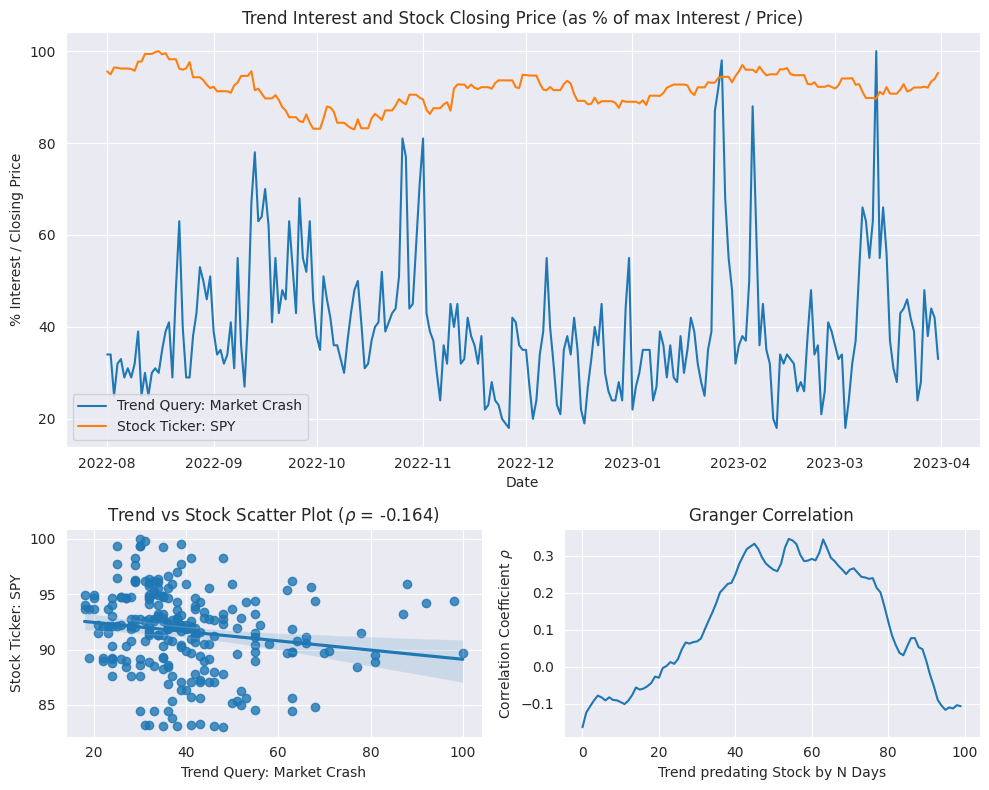

In [4]:
# Display the widgets and button
widgets.interact_manual(get_trend_and_plot, trend_query="Market Crash",
                        stock_ticker="SPY", start_date="2022-08-01",
                        end_date="2023-04-01", daily_returns=False);

Voilà. Now you can investigate the correlation between any Google Search Trend and any stock listed on Yahoo Finance.

___

A final word to note is one of caution: Just because we might see a large correlation for some stock with some trend does not mean that this correlation will continue in the future. The stock market is a very complex system and you will see that for the same trend-stock relation over different time frames, the correlation can vary broadly. Additionally, you need to be aware that correlation does not equal causation. Sometimes it might seem like the trend is meaningfully predicting the stock, but this might just be a reverse relation that's originally caused by the stock movement. For an example of this, check the relation between the query `Bank Run` and the Silicon Valley Bank `SIVB` in early 2023. 😉

So while there's still a lot more to do before being able to turn this information into a profitable trading strategy, it's a great start and gives some intuition on how the finance world works.